# Extraction and analysis of a database of tweets

# Analysis of a tweet database

### Presentation of the dataset

In [2]:
import csv
import time
import sys
from twython import Twython, TwythonError, TwythonRateLimitError

In [3]:
twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, oauth_token, oauth_secret)

In [1]:
filename = "gwu/news_outlets.txt"
database_name = "databases/real_data_exctraction.csv"

def write_csv(tweet_list, features, writer):
    tweets_dicts = []
    for tweet in tweet_list:
        temp_dict = {}
        for feature_list in features:
            if len(feature_list) > 1:
                temp_dict[feature_list[1]] = tweet[feature_list[0]][feature_list[1]]
            else:
                temp_dict[feature_list[0]] = tweet[feature_list[0]] 
        tweets_dicts.append(temp_dict)

    for tweet_dictionary in tweets_dicts:
        writer.writerow(tweet_dictionary)
        
def hydrate_database(filename, database_name, 
                     features, nb_requests, 
                     tweet_hydratation_limit=100):
    """
    Create a csv file that contains features of tweets from an file that contains ID of tweets.
    
    filename: Name of the file that contains ids
    database_name: name of the file that will be created
    features: List of features
    nb_requests: number of time the function lookup_status will be called
    tweet_hydratation_limit:
    """

    # Creation of the file that will contain the hydrated tweets:
    with open(database_name, 'w', newline='', encoding="utf-8") as csvfile:
            tweet_test = None
            # Opening the ID File:
            id_list = []
            file = open(filename, "r")
            for line in file:
                id_list.append(line.rstrip("\n"))
               
            fieldnames = []
            # constructing the features list                
            for feature_list in features:
                if len(feature_list) > 1:
                    fieldnames.append(feature_list[1])
                else:
                    fieldnames.append(feature_list[0])
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            for i in range(nb_requests + 1):     
                try: # If you don't reach the limit of requests
                    tweet_test = twitter.lookup_status(id = id_list[i*tweet_hydratation_limit:(i*tweet_hydratation_limit)+tweet_hydratation_limit])
                    write_csv(tweet_test, features, writer)
                except TwythonError as e:
                    if isinstance(e, TwythonRateLimitError):
                        retry_after = int(e.retry_after)
                        #Get the difference between the current time and the time where it should retry 
                        wait_time = retry_after - time.time()
                        print(wait_time)
                        time.sleep(wait_time + 2)
                       #Apres avoir sleep on vx refaire l'iteration i
                        tweet_test = twitter.lookup_status(id = id_list[i*tweet_hydratation_limit:(i*tweet_hydratation_limit)+tweet_hydratation_limit])
                        write_csv(tweet_test, features, writer)
                except Exception as e:
                    print('An error has occured :' + e)
               
    file.close()

In [104]:
features = [['text'], ['user', 'location'], ['user', 'screen_name'],['user', 'name'], ['created_at'], ['lang'], ['retweet_count'], ['favorite_count'], ['user','description']]
nb_requests = 5000

hydrate_database(filename, database_name, features, nb_requests, tweet_hydratation_limit=100)

681.9940612316132
675.1971881389618
674.07248878479
671.2457621097565
673.6545670032501


### Reading hydrated data

In [2]:
import pandas as pd

In [3]:
colnames = ['text', 'location','screen_name', 'name','created_at', 'lang', 'retweet_count', 'favorite_count', 'description' ]
data = pd.read_csv(database_name, names=colnames)
text = data.text.tolist()
location = data.location.tolist()
screen_name = data.screen_name.tolist()
name = data.name.tolist()
created_at = data.created_at.tolist()
languages = data.lang.tolist()
retweet_count = data.retweet_count.tolist()
favorite_count = data.favorite_count.tolist()
description = data.description.tolist()
all_attributes = [text, location, created_at, languages, description, favorite_count, retweet_count, name, screen_name]

c:\users\mohamed ali elakhras\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



### Preprocessing


In [5]:
import sys
import nltk

##### Filtering non-English tweets

In [6]:
indexes_to_keep = []

class TweetsFilter(object):
    def remove_non_english(self, all_attributes):
        all_eng_attributes = []
        for i, value in enumerate(all_attributes[3]):
            if value == "en":
                indexes_to_keep.append(i)
        for attribute_list in all_attributes:
            new_list = [] 
            for index in indexes_to_keep:
                new_list.append(attribute_list[index])
            all_eng_attributes.append(new_list)
            
        return all_eng_attributes

In [7]:
tweet_filter = TweetsFilter()
all_eng_attributes = tweet_filter.remove_non_english(all_attributes)
text = all_eng_attributes[0]
location = all_eng_attributes[1]
created_at = all_eng_attributes[2]
languages = all_eng_attributes[3]

##### Removing emojis

In [8]:
import emoji
class EmojisRemover(object):
    
    def remove_emojis(self, text):
        allchars = [str for str in text]
        emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
        clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
        return clean_text

##### Tokenization using TweetTokenizer

In [9]:
from nltk.tokenize import TweetTokenizer

class NLTKTokenizer(object):
    
    def tokenize(self, text):
        text = text.lower()
        tweetTokenizer = TweetTokenizer(preserve_case=False,
                               reduce_len=True,
                               strip_handles=False)
        splitTweet = tweetTokenizer.tokenize(text)
        pre_words = []
        for word in splitTweet:
            # Mot alphabetique, stop words et longueur de 1
            if word.isalpha() and len(word) > 1:
                pre_words.append(word)

        # Have to return a list of tokens
        return pre_words


##### Remove Stopwords

In [10]:
from nltk.corpus import stopwords
class StopwordsRemover(object):
    def remove_stopwords(self, tweet):
        stopwords_list = set(stopwords.words("english"))
        return [token for token in tweet if token not in stopwords_list]
       

##### Stemming 

In [11]:
from nltk.stem.snowball import SnowballStemmer

class Stemmer(object):

    def __init__(self):
        self.stemmer = SnowballStemmer("english")

    def stem(self, tokens):
        """
        tokens: a list of strings
        """
        stems = map(self.stemmer.stem, tokens)
        # Have to return a list of stems
        return list(stems)

##### Removal of punctuation, http links and the word "RT"

In [12]:
import string
import re

class UselessInfoRemover(object):
    def remove_useless_info(self, tweet):
        punctuations = ['.', ',', '?', '!', "'", '"', ';', ':', '...', '-', '_', '(', ')', '[', ']']
        new_tweet = []
        for word in tweet:
            if word not in punctuations and not re.search(r'\d', word) and word.find('http') == -1 and word.find('https') == -1 and word.find('rt') == -1:
                new_tweet.append(word)
        # return the preprocessed twitter
        return new_tweet

#### Preprocessing pipeline

In [13]:
class PreprocessingPipeline:

    def __init__(self, emoji_remover, tokenization, stopwords_remover, useless_info_remover, stemming):
        """
        tokenization: enable or disable tokenization.
        punctuation_remover: enable or disable twitter preprocessing.
        stemming: enable or disable stemming.
        """
        self.emoji_remover = EmojisRemover() if emoji_remover else None
        self.stopwords_remover = StopwordsRemover() if stopwords_remover else None
        self.tokenizer = NLTKTokenizer() if tokenization else None
        self.useless_info_remover = UselessInfoRemover() if useless_info_remover else None
        self.stemmer = Stemmer() if stemming else None

    def preprocess(self, tweet):
        """
        Transform the raw data

        tokenization: boolean value.
        punctuation_remover: boolean value
        stemming: boolean value.
        """
        if self.emoji_remover:
            new_tweet = self.emoji_remover.remove_emojis(tweet)
            
        if self.tokenizer:
            tokens = self.tokenizer.tokenize(new_tweet)
            
        if self.stopwords_remover:
            tokens= self.stopwords_remover.remove_stopwords(tokens)
        
        if self.stemmer:
            tokens = self.stemmer.stem(tokens)   

        if self.useless_info_remover:
            tokens = self.useless_info_remover.remove_useless_info(tokens)

        return tokens
    
    def preprocess_contents(self, list_tweets):
        preprocessed_tweets = []
        for tweet in list_tweets:
            preprocessed_tweets.append(self.preprocess(tweet))
        return preprocessed_tweets

In [14]:
pipeline = PreprocessingPipeline(emoji_remover=True, tokenization=True, stopwords_remover = True, useless_info_remover=True, stemming=True)

Preprocessing of tweets

In [15]:
preprocessed_tweets = pipeline.preprocess_contents(text)

Test preprocessed data

In [16]:
print(preprocessed_tweets[:10])

[['timelin', 'fidel', 'life'], ['poll', 'open', 'kuwait', 'opposit', 'return'], ['havana', 'music', 'stop', 'cuban', 'mourn', 'father', 'castro'], ['foldabl', 'cardboard', 'tube', 'bring', 'easi', 'eye', 'test', 'develop', 'world'], ['mariann', 'faithful', 'pay', 'homag', 'pari', 'victim', 'bataclan'], ['pope', 'everyman', 'reaction', 'death', 'former', 'cuban', 'presid', 'fidel', 'castro'], ['iran', 'arrest', 'three', 'dead', 'train', 'crash'], ['brutal', 'dictat', 'legaci', 'oppress', 'fire', 'squad', 'say', 'statement'], ['thousand', 'ralli', 'demand', 'korea', 'ouster'], ['remind', 'still', 'got', 'barack', 'obama', 'month']]


## TF-IDF Vectorization 

In [19]:
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [20]:
def build_voc(n):

    counts = Counter(word for doc in preprocessed_tweets for word in doc)
    voc = {word for word, freq in counts.most_common(n)}
    
    return voc

In [21]:
voc = build_voc(8000)

In [22]:
tweets = [' '.join(tweet) for tweet in preprocessed_tweets]
vec = TfidfVectorizer(vocabulary=voc)
tf_idf_matrix = vec.fit_transform(tweets)

## K-Means algorithm WITHOUT IMPROVEMENT

In [85]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

#### Application of the K Means model to the TF-IDF matrix

In [29]:
random_k = 100
seed = 42
regular_km_model = KMeans(n_clusters=random_k, n_jobs=-1, random_state=seed)
regular_km_model.fit(tf_idf_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=100, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

#### Graphical representation of clusters

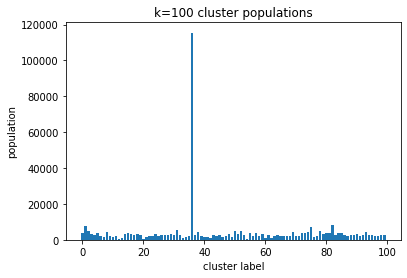

In [30]:
plt.bar(range(len(set(regular_km_model.labels_))), np.bincount(regular_km_model.labels_))

plt.ylabel('population')
plt.xlabel('cluster label')
plt.title('k={} cluster populations'.format(random_k));

#### Let's print the most frequent words in each clusters

In [31]:
def strongest_features(model, vectorizer, topk=10):
    """
    Helper function to display a simple text representation of the top-k most
    important features in our fit model and vectorizer.

    model: sklearn model
    vectorizer: sklearn vectorizer
    topk: k numbers of words to get per cluster

    """
    # these parts are model-independent
    m_name = model.__class__.__name__
    features = vectorizer.get_feature_names()
    # different calculations per model type
    if m_name is 'KMeans':
        relevant_labels = list(set(model.labels_))
        centroids = model.cluster_centers_.argsort()[:,::-1]
        for this_label in relevant_labels:
            print('Cluster {}:'.format(this_label), end='')
            for ind in centroids[this_label, :topk]:
                print(' {}'.format(features[ind]), end='')
            print()
    else:
        raise NotImplementedError('This helper method currently only supports KMeans')

In [32]:
strongest_features(regular_km_model, vec, topk=15)

Cluster 0: win titl first award macron championship gold big democrat state bowl girl nation boy enter
Cluster 1: new york video name plan day book jersey say post orlean law eve releas launch
Cluster 2: live watch follow facebook updat video coverag talk peopl stream tune winter right matter today
Cluster 3: news fox fake daili detail good follow break seth stori week rich latest local dnc
Cluster 4: photo galleri day ap week new best share year take video celebr look post imag
Cluster 5: counti sheriff offic jail commission board arrest school man new charg vote deputi crash orang
Cluster 6: public school safeti librari record counti new hear open first meet servic teacher work health
Cluster 7: secur homeland advis nation resign tom trump bolton council social hous white say clearanc guard
Cluster 8: make sure trump way debut new want peopl say histori money via day feel great
Cluster 9: health care mental bill gop senat republican vote insur surgeri mccain mcconnel delay new say
Cl

#### Get tweets from a cluster

In [30]:
def cluster_sample(orig_text, model, idx, preview=15):
    """
    Helper function to display original bio for
    those users modeled in cluster `idx`.
    """
    print("Nombre de tweets dans le cluster " + str(idx) + ": "+ str(len(np.where(model.labels_ == idx)[0])))
    for i,idx in enumerate(np.where(model.labels_ == idx)[0]):
        print(orig_text[idx].replace('\n',' '))
        print()
        if i > preview:
            print('( >>> truncated preview <<< )')
            break

In [182]:
cluster_id = 36

cluster_sample(text, regular_km_model, cluster_id)

Nombre de tweets dans le cluster 36: 115431
Here's what your member of Congress can actually do for you https://t.co/dEydO5vohZ https://t.co/X1G9cC0b7k

Wave of Mexico violence reveals hidden graves, severed heads https://t.co/1zB7LsGdjh https://t.co/9nEBe2QGLQ

$20K reward offered for 2 men who escaped California jail https://t.co/l0wWITEMQG https://t.co/fLZw4KZudV

Smithsonian National Zoo's panda Bei Bei recovering after "lemon-sized mass of bamboo" removed from small intestine… https://t.co/HMCyUrivnG

Iraq's Najaf cemetery swells as fight against ISIS escalates https://t.co/8mx1gcumwn https://t.co/JzGasQk5wp

Demonetisation has reduced crime rate in Mumbai: Defence Minister Manohar Parrikar. https://t.co/Rjsz1e9i3v https://t.co/OT6HB9yf7Z

Plan to create biodiversity map identifying aquatic species in every river and stream in western U.S. is underway.… https://t.co/8PXFx0LsSg

#ieWorld Syrian government advances into rebel-held east Aleppo https://t.co/CK3t17X4AM https://t.co/kFn

In [183]:
cluster_id = 87

cluster_sample(text, regular_km_model, cluster_id)

Nombre de tweets dans le cluster 87: 2311
The first American to die in combat in Syria: Scott Dayton, a 42-year-old Navy sailor  https://t.co/P6zjbQN9O1

A hot souvenir from Cuba for some Americans: A cancer vaccine https://t.co/0lRYv4um51

Scott Dayton Identified as First American to Die in Syria Combat https://t.co/f0pd6hJBEF

Breaking News: Fidel Castro has died at 90. The Cuban revolutionary was a nemesis to 11 American presidents. https://t.co/01wGISur9L

Disney archivist Dave Smith spent 40 years preserving the history of an American icon https://t.co/QmhAjRlB1L https://t.co/0QrNzWo9ze

The keeper of Disney's legacy, archivist Dave Smith spent 40 years preserving the history of an American icon https://t.co/wlE2n72Coc

American President-Elect Trump and Third World Concerns: https://t.co/O43FVznNJ9 #Africa https://t.co/tdoYgs0Tvf

Naval officer Scott Dayton identified as first American killed in Syria https://t.co/oh4Ir8qhHl https://t.co/GWmW9Gicay

Why the American left should b

## K-Means algorithm WITH IMPROVEMENT

#### Build a TF-IDF matrix taking into account bigrams and trigrams

In [23]:
vectorizer = TfidfVectorizer(max_features=8000, ngram_range=(1, 3))
tf_idf_matrix_ngrams = vectorizer.fit_transform(tweets)

#### Find the number of clusters with the elbow method

In [ ]:
# compare a broad range of ks to start
ks = [2, 50, 200, 250, 350]

# track a couple of metrics
inertias = []

# fit the models, save the evaluation metrics from each run
for k in ks:
    print('fitting model for {} clusters'.format(k))
    model = KMeans(n_clusters=k, n_jobs=-1, random_state=seed, verbose=1)
    model.fit(tf_idf_matrix_ngrams)
    labels = model.labels
    inertias.append(model.inertia_)

fitting model for 2 clusters
fitting model for 50 clusters
fitting model for 200 clusters
fitting model for 250 clusters


Figure 2: Visualization of the elbow for the tfidf matrix with the ngrams

In [ ]:
# plot the quality metrics for inspection
plt.style.use("bmh")
fig, ax = plt.subplots(1, 1, sharex=True)
plt.subplot(211)
plt.plot(ks, inertias, 'o--')
plt.ylabel('inertia')
plt.title('kmeans parameter search')

<img src="bestk.png">

Using the elbow method, we get a number of clusters of 200

#### Reduce dimensionality

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

In [25]:
X_std = StandardScaler(with_mean=False).fit_transform(tf_idf_matrix_ngrams)

In [26]:
clf = TruncatedSVD(100,  random_state = 42)
svg = clf.fit_transform(tf_idf_matrix_ngrams)

#### Apply KMeans with the ideal number of clusters on the dimension matrix reduced by 2

In [27]:
best_k= 200
seed = 42
better_km_model = KMeans(n_clusters=best_k, n_jobs=-1, verbose=1, random_state=seed)
better_km_model.fit(svg)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=200, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=1)

#### Graphic representation of the 200 clusters

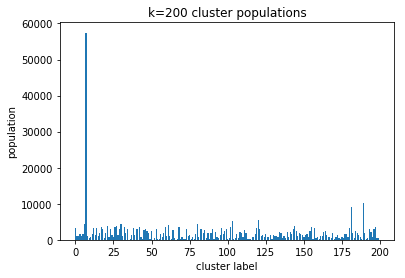

In [28]:
plt.bar(range(len(set(better_km_model.labels_))), np.bincount(better_km_model.labels_))

plt.ylabel('population')
plt.xlabel('cluster label')
plt.title('k={} cluster populations'.format(best_k));

#### Viewing tweets by cluster

In [51]:
cluster_id = 7

cluster_sample(text, better_km_model, cluster_id)

Nombre de tweets dans le cluster 7: 57438
In Havana, music stops as Cubans mourn 'father' Castro https://t.co/rKzhGyabn6 https://t.co/USkbiCbAXL

Marianne Faithfull pays homage to Paris victims at Bataclan https://t.co/kchA0HcuiA https://t.co/00OpeneevO

Afghan, Pakistani Leaders Discuss Tense Bilateral Ties https://t.co/KWlTCjR0CD https://t.co/JjZThztAno

Fidel Castro's military forays into Africa https://t.co/4O4zG25NEa https://t.co/FfXOCdtsCr

Bay of Pigs: America's Waterloo in anti-Castro fight https://t.co/CwdVZAJIqa https://t.co/IcamsAycur

The 37 iconic bridges that span the Seine in Paris https://t.co/SZFISqJe4x

Rooney 'cleared over drinking storm' https://t.co/REE1pX63nV https://t.co/sdXRU5vtLK

More casualties reported among Turkish soldiers in Syria https://t.co/TRRc7rD28p https://t.co/VDd7SfuNvc

Bargain Hunters Excited About Black Friday https://t.co/JgOUFmKC32 https://t.co/rUHrpI4Htk

Credit Suisse estimates Turkmenistan has the most wealth per adult citizen: https://t.c

In [34]:
cluster_id = 9

cluster_sample(text, better_km_model, cluster_id)

Nombre de tweets dans le cluster 9: 540
Teacher gets Brockway High School students career ready https://t.co/7cKvDArDgJ

Chesapeake High School students greeted with signs of equality by local community https://t.co/7P5SSNSiPM https://t.co/uiEKFKulbE

Chesapeake High School students greeted with signs of equality by local community https://t.co/GT1PTyc7BD https://t.co/rNNmPSW1xO

Chesapeake High School students greeted with signs of equality by local community https://t.co/n4ufWgOAXZ https://t.co/vb1FsA1l8p

Chesapeake High School students greeted with signs of equality by local community https://t.co/tHmIyP4Ja6 https://t.co/Q1CdPV0SUD

The woman told fellow nurses she had a "make out session" with the high school student, and then described having s… https://t.co/XXt3JyCeHL

A note to any high school student who feels violated by using clear backpacks: https://t.co/TAbLb479Et https://t.co/9AzWUqVDJm

Teachers remember high school student day after deadly shooting https://t.co/BAgSAyt9

## Improvement using LDA

#### Get the token counts matrix

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

In [36]:
tf_vectorizer = CountVectorizer(vocabulary=voc)
tf = tf_vectorizer.fit_transform(tweets)
tf_feature_names = tf_vectorizer.get_feature_names()

#### Get ideal parameter values

In [ ]:
# Ce code est brise. https://github.com/scikit-learn/scikit-learn/issues/6777
search_params = {'n_components': [5, 20, 30, 40], 'learning_decay': [.5, .7, .9]}

lda = LatentDirichletAllocation()

model = GridSearchCV(lda, param_grid=search_params, n_jobs=-1)

model.fit(tf)

In [ ]:
print(model.cv_results_['params'][model.best_index_])

#### LDA model with learning_method = 'batch'

In [53]:
no_topics = 200

lda_batch = LatentDirichletAllocation(n_components=no_topics, n_jobs=1,random_state=0).fit(tf)

#### LDA with learning_method = 'online'

In [38]:
no_topics = 200
lda = LatentDirichletAllocation(n_components=no_topics, n_jobs=1, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

### Display and evaluation of topics

In [63]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic: "+ str(topic_idx))
        print (" ".join([feature_names[i]
        for i in topic.argsort()[:-no_top_words - 1:-1]]))

#### List of topics

In [65]:
no_top_words = 50
display_topics(lda, tf_feature_names, no_top_words)

Topic: 0
sign wednesday execut excit htt jim disney el impress weed chuck hunter mueller marri schumer ex harm interfer horror meddl retweet hbo kimmel saga des grandma roast grassley furi moham lg pact bargain unfold sophist throwback salman referr wolverin appetit surpass morocco breakup beam homemad brake unload ought fin fernando
Topic: 1
kill car market least assault britain cia blame blast crowd nba shift fame rip expens troop butler asian broadcast cathol collis greg dame stole bizarr coron fm consecut sydney premium horrif elli tr panic intellectu skid align faulti horrifi somali medium granddaught sy sinclair cbc filipino zuma fill film filmmak
Topic: 2
ford besid bryce zuma final find financi financ finalist fin finest filter filmmak film fill filipino fine finger figur fingerprint finish finland finn fintech fir fire firearm firefight firework firm first file fighter fiscal fewer femin feminist fenc fend fentanyl ferguson fernando ferrel ferri fest festiv feud fever fey figh

#### Distribution of topics through tweets

In [41]:
# Create Document - Topic Matrix
lda_output = lda.transform(tf)

# column names
topicnames = ["Topic" + str(i) for i in range(lda.n_components)]

# index names
docnames = [ i for i in range(len(text))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)



Table 1: Association of each tweet with the most likely topic

In [42]:
# Apply Style
df_document_topics = df_document_topic.head(50).style.applymap(color_green).applymap(make_bold)
df_document_topics

#### List of the first 50 tweets

In [43]:
for i, tweet in enumerate(text[:50]):
    print("Tweet " + str(i) + ":" + text[i])
print()

Tweet 0:Timeline of Fidel Castro's life https://t.co/HgN0iyQz0L https://t.co/c59GxrRaMx
Tweet 1:Polls open in Kuwait as opposition returns https://t.co/IBfZPJ9Ilt https://t.co/1rUoNmdPcq
Tweet 2:In Havana, music stops as Cubans mourn 'father' Castro https://t.co/rKzhGyabn6 https://t.co/USkbiCbAXL
Tweet 3:Foldable Cardboard Tube Brings Easy Eye Test to Developing World https://t.co/XqjGpyjoVk https://t.co/o1N0o4I90g
Tweet 4:Marianne Faithfull pays homage to Paris victims at Bataclan https://t.co/kchA0HcuiA https://t.co/00OpeneevO
Tweet 5:Pope to Everyman: Reaction to the Death of former Cuban President Fidel Castro https://t.co/EvSi0c9qKy https://t.co/BtuQ8PEsCM
Tweet 6:Iran arrests three over deadly train crash https://t.co/b8Q2n3NBEh https://t.co/ESnUgszf7T
Tweet 7:RT @W7VOA: #FidelCastro a "brutal dictator" with a legacy of oppression and firing squads, says @realDonaldTrump statement. https://t.co/t6…
Tweet 8:Thousands rally to demand S. Korea president's ouster https://t.co/WwhooP7

#### Visualization of word distribution in topics

In [45]:
import pyLDAvis
import pyLDAvis.sklearn

Representation of the dispersion of topics and their most frequent words for LDA with batch

In [54]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_batch, tf, tf_vectorizer, mds='tsne')
panel

c:\users\mohamed ali elakhras\appdata\local\programs\python\python37\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
45    -173.295227   -7.963272       1        1  1.317954
125     19.382483  182.815750       2        1  1.300865
25    -103.127846   78.152229       3        1  0.989613
2      206.847870  -19.851419       4        1  0.978974
60    -151.973816  -35.690311       5        1  0.905371
...           ...         ...     ...      ...       ...
52     102.066711  -51.434250     196        1  0.293885
92      -3.256010 -187.341141     197        1  0.287852
11    -415.904175  -24.664770     198        1  0.283832
41    -127.953903  203.368027     199        1  0.280455
24      26.778177  119.515549     200        1  0.279960

[200 rows x 5 columns], topic_info=      Category          Freq      Term         Total  loglift  logprob
6221   Default  13112.000000    school  13112.000000  30.0000  30.0000
1831   Default   8961.000000       day   8961.000000  29.0000  29.0000
4952   Default   8823.000000       one   8823.000000  28.0000  28.0000
6865   Default  12064.000000   student  12064.000000  27.0000  27.0000
7370   Default  19006.000000     trump  19006.000000  26.0000  26.0000
...        ...           ...       ...           ...      ...      ...
234   Topic200    134.211053  american   3062.396517   2.7507  -4.0646
4768  Topic200    112.704156       new  21480.585635   0.6281  -4.2393
3278  Topic200     84.940040      help   5159.550285   1.7716  -4.5221
5198  Topic200     67.405468     peopl   6142.993141   1.3659  -4.7533
493   Topic200     53.907607      back   5374.324697   1.2762  -4.9768

[8322 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0       124  0.991494         aaa
2        52  0.989957         aap
3        63  0.021052       aaron
3       155  0.975427       aaron
4       104  0.982269          ab
...     ...       ...         ...
7996     18  0.955036         zoo
7996    128  0.039383         zoo
7997    191  0.988505         zte
7998     35  0.999406  zuckerberg
7999     70  0.979807        zuma

[40742 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[46, 126, 26, 3, 61, 85, 133, 2, 84, 28, 197, 68, 52, 178, 48, 71, 150, 73, 198, 10, 29, 63, 40, 75, 14, 95, 31, 82, 92, 89, 96, 168, 60, 172, 171, 99, 45, 135, 187, 200, 66, 124, 186, 18, 177, 132, 15, 140, 104, 21, 195, 111, 105, 106, 139, 117, 183, 130, 155, 173, 20, 91, 56, 49, 13, 102, 17, 37, 78, 179, 50, 33, 47, 116, 174, 113, 70, 54, 146, 158, 184, 151, 191, 80, 121, 100, 98, 160, 189, 107, 59, 148, 16, 4, 180, 170, 103, 123, 188, 109, 62, 69, 147, 154, 24, 65, 138, 190, 193, 134, 119, 164, 165, 136, 36, 167, 115, 79, 87, 22, 161, 143, 128, 7, 11, 144, 44, 169, 152, 55, 83, 199, 39, 108, 112, 76, 86, 196, 131, 127, 27, 81, 5, 51, 114, 129, 157, 32, 122, 38, 163, 34, 101, 43, 110, 166, 90, 137, 64, 118, 159, 97, 30, 9, 185, 67, 6, 58, 153, 72, 120, 77, 142, 19, 181, 1, 141, 35, 88, 57, 8, 162, 145, 156, 192, 94, 176, 175, 194, 74, 149, 182, 125, 41, 23, 53, 93, 12, 42, 25])

Representation of the dispersion of topics and their most frequent words for LDA with online

In [47]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer, mds='tsne')
panel

c:\users\mohamed ali elakhras\appdata\local\programs\python\python37\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
51       0.175731    2.628462       1        1  1.578758
161     -1.616161    9.617355       2        1  1.544953
58       0.836508   -0.701659       3        1  1.480015
127      1.613764    8.241212       4        1  1.455835
132   -239.876816 -170.312775       5        1  1.450164
...           ...         ...     ...      ...       ...
102     -2.622256    3.653520     196        1  0.066519
59      -2.258643    0.630401     197        1  0.066428
42     -10.831162    0.746788     198        1  0.066383
136     -7.825919    3.184652     199        1  0.065986
118     -5.207522    2.027295     200        1  0.064998

[200 rows x 5 columns], topic_info=      Category          Freq       Term         Total  loglift  logprob
4768   Default  20361.000000        new  20361.000000  30.0000  30.0000
6196   Default  16809.000000        say  16809.000000  29.0000  29.0000
7370   Default  17863.000000      trump  17863.000000  28.0000  28.0000
6221   Default  14975.000000     school  14975.000000  27.0000  27.0000
6865   Default  14338.000000    student  14338.000000  26.0000  26.0000
...        ...           ...        ...           ...      ...      ...
2679  Topic200      0.134604        fir     84.768349   0.8932  -9.5092
2680  Topic200      0.134604       fire   6482.870370  -3.4438  -9.5092
2681  Topic200      0.134604    firearm    218.828321  -0.0551  -9.5092
2682  Topic200      0.134604  firefight    596.636044  -1.0582  -9.5092
2683  Topic200      0.134604   firework    147.230951   0.3412  -9.5092

[8906 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3       119  0.996641       aaron
5        34  0.984147     abandon
10       72  0.972896         abc
11       82  0.966658      abduct
17       76  0.989384         abl
...     ...       ...         ...
7987      1  0.978003     zealand
7988     40  0.980485        zero
7995     39  0.990108        zone
7996     88  0.977787         zoo
7998     85  0.973402  zuckerberg

[3318 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[52, 162, 59, 128, 133, 168, 55, 22, 58, 126, 116, 154, 53, 49, 78, 171, 195, 30, 152, 26, 185, 66, 143, 85, 67, 140, 36, 34, 104, 11, 65, 9, 73, 176, 41, 183, 17, 178, 196, 13, 177, 134, 48, 160, 74, 57, 25, 114, 164, 75, 191, 31, 147, 6, 165, 45, 175, 110, 190, 33, 35, 156, 12, 86, 113, 125, 16, 2, 150, 80, 83, 122, 174, 42, 120, 64, 127, 90, 21, 163, 188, 97, 200, 121, 109, 69, 28, 19, 1, 115, 157, 149, 129, 18, 70, 189, 182, 62, 46, 181, 186, 112, 138, 159, 124, 93, 5, 123, 194, 106, 102, 148, 142, 141, 20, 151, 3, 166, 139, 51, 24, 56, 91, 118, 199, 27, 95, 98, 117, 61, 101, 37, 7, 179, 155, 77, 15, 100, 38, 170, 172, 184, 167, 14, 79, 87, 180, 88, 81, 135, 40, 108, 130, 193, 99, 146, 23, 169, 192, 161, 39, 76, 29, 111, 89, 145, 82, 84, 187, 173, 92, 68, 47, 158, 153, 32, 10, 4, 72, 136, 197, 96, 105, 94, 8, 144, 71, 50, 63, 44, 132, 198, 131, 54, 107, 103, 60, 43, 137, 119])

#### Get the most likely words in each topic

In [57]:
df_topic_keywords = pd.DataFrame(lda.components_)
topicnames = ["Topic" + str(i) for i in range(lda.n_components)]
# Assign Column and Index
df_topic_keywords.columns = tf_vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

aaa  aadhaar    aap  aaron     ab  abandon   abba  abbey   abbi  \
Topic0  0.005    0.005  0.005  0.005  0.005    0.005  0.005  0.005  0.005   
Topic1  0.005    0.005  0.005  0.005  0.005    0.005  0.005  0.005  0.005   
Topic2  0.005    0.005  0.005  0.005  0.005    0.005  0.005  0.005  0.005   
Topic3  0.005    0.005  0.005  0.005  0.005    0.005  0.005  0.005  0.005   
Topic4  0.005    0.005  0.005  0.005  0.005    0.005  0.005  0.005  0.005   

        abbott  ...  zimbabw   zink   zion    zip  zombi   zone    zoo    zte  \
Topic0   0.005  ...    0.005  0.005  0.005  0.005  0.005  0.005  0.005  0.005   
Topic1   0.005  ...    0.005  0.005  0.005  0.005  0.005  0.005  0.005  0.005   
Topic2   0.005  ...    0.005  0.005  0.005  0.005  0.005  0.005  0.005  0.005   
Topic3   0.005  ...    0.005  0.005  0.005  0.005  0.005  0.005  0.005  0.005   
Topic4   0.005  ...    0.005  0.005  0.005  0.005  0.005  0.005  0.005  0.005   

        zuckerberg   zuma  
Topic0       0.005  0.005  
Topic1       0.005  0.005  
Topic2       0.005  0.005  
Topic3       0.005  0.005  
Topic4       0.005  0.005  

[5 rows x 8000 columns]

### Study through time

In [66]:
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#### Distribution of all tweets over time

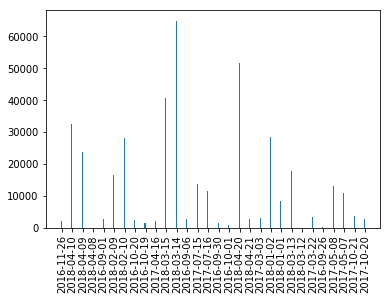

In [84]:
list_date = []
for date in created_at:
    list_date.append(datetime.strptime(date, '%a %b %d %H:%M:%S %z %Y').date())
    
labels, values = zip(*Counter(list_date).items())

indexes = np.arange(len(labels))
width = 0.1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels, rotation=90)
plt.show()

#### Distribution of topic 16 tweets over time

In [68]:
df_topics = pd.DataFrame(df_document_topic)
list_indexes_topic_16 = df_topics.index[df_topics['dominant_topic'] == 16].tolist()

In [69]:
list_date_topic_16 = []
for index in list_indexes_topic_16:
    list_date_topic_16.append(datetime.strptime(created_at[index], '%a %b %d %H:%M:%S %z %Y').date())

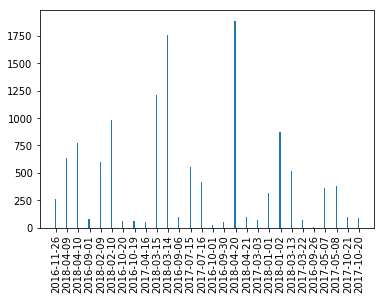

In [83]:
labels, values = zip(*Counter(list_date_topic_16).items())

indexes = np.arange(len(labels))
width = 0.1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels, rotation=90)
plt.show()